In [1]:
# %matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

# matplotlib settings
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler
matplotlib.rc("font", family="serif", size=14)
matplotlib.rc("figure", figsize="10, 5")
colors = ['k', 'c', 'm', 'y']
matplotlib.rc('axes', prop_cycle=cycler("color", colors))

# import modules
import numpy as np
import keras
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Conv1D, Dense, Flatten
from keras import backend as K
from keras.callbacks import TensorBoard

# Healpix python module
import healpy as hp

# Drawing NN code here: https://gist.github.com/craffel/2d727968c3aaebd10359
# designed by craffel
from draw_neural_net import draw_neural_net

/Users/cicero/anaconda/envs/viper/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# A Simple Solution for CNN on Spheres: using Hierarchical Spherical Data

Here we show an interesting application for convolutional neural network on spheres: using `Healpix` to do classification of MNIST on spheres. We would not dive into the details CNN theory because we'd only like to show some results of the CNN predictions on spherical data. The simplest one for CNN task is to predict MNIST hand-written digits.


For people who are not quite familiar with the idea of convolution filter, please find the resources here:

- [Cool 3D visualization for CNN](http://scs.ryerson.ca/~aharley/vis/conv/), 
- [Keras' CNN see the world](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html), 
- [Hung-Yi Lee's lecture on CNN](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2017/Lecture/CNN.pdf)

The basic idea of CNN filter is to use a relative smaller size matrix to loop over ever pixels of an image, and the output of the filters (also a matrix) could be applied an another filter on it.

For example, for a filter (with a size of $4\times 4$) moving on an image (with a size of $16\times16$), if the filter moves for every pixels with zero padding on the original image, the output size for **"looping + filter"** would be smaller than the original size ($16\times16 \rightarrow 13\times13$). You can imagine each matrix element in a filter constitutes an activation function (usually a non-linear function) and a linear regression (so that the output is $act(\beta \times x + \alpha)$, $act$: activation function, $\beta \times x + \alpha$: linear regression). The benefit of training on CNN filters is the emphasis on the local properties, since the weights of the neurons are trained within a limited size of CNN filter. For people interests in a quick introduction of neural network and back-propagation, there's a series of great 3B1B [videos](http://www.3blue1brown.com/videos/2017/10/9/neural-network) for it.

However, the big question here is how to connect the idea of CNN filter with a spherical data? A navie approach is to use the tangential projection on different angles and directly use projected rectangle images to train in an usual way. I haven't tried that, but I think that would work fine. But, in this tutorial, I want to show an interesting trick to render CNN filter directly works on spherical data: that is using `Healpix`.

This may not draw your eyes at first, but let me explain it using a simplistic tongue: the key point of CNN could work perfectly on ordinary rectangle data (matrices) is that the output shape of each layer in CNN is the same rectangle data structure, so the multilevel neural network construction can apply on ordinary images, hierarchically. The interesting point here is that `Healpix` itself is a hierarchical data structure, so, on its native characteristic, CNN could be built on it hierarchically. Back to the Healpix paper, you can see the ordering of Healpix pixels is (0: lower, 1: right, 2: left, 3: top) and for every 4 pixels it can be grouped as a bigger pixel for the next layer of ordering (0: lower, 1: right, 2: left, 3: top). 

The natural way to use CNN on Healpix is using `1DConv` and grouped every 4 elements as a filter and move for every 4 pixels in an array. Just think about this:

- for nest ordering, `0~15` could be clustered as `[0~3] | [4~7] | [8~11] | [12~15]`. 
- If we apply `1DConv` with `filter_size = (4, ) & stride=4`, the CNN process can also process hierarchically. 

No more jibber-jabber, let's practicing with MNIST.

In [3]:
# an illustration for the CNN on Healpix + NN process
# it seems many people are trying to do CNN illustration, 
# resources: D3 
## https://bl.ocks.org/e9t/6073cd95c2a515a9f0ba
# resources: matplotlib 
## https://github.com/gwding/draw_convnet/blob/master/draw_convnet.py
# here I used https://gist.github.com/craffel/2d727968c3aaebd10359 for NN
# TODO: make this plot prettier

plt.figure(figsize=(14, 6))
gs = matplotlib.gridspec.GridSpec(1, 4, width_ratios=[4, 2, 1, 2,], ) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

# haven't find a better way to interact between healpy and axes
plt.axes(ax0)
hp.orthview(np.arange(hp.nside2npix(8)), 
            nest=1, cbar=0, title='Nside=8', half_sky=1, sub=(1,4,1), min=752, hold=1)
plt.axes(ax1)
hp.orthview(np.arange(hp.nside2npix(4)), 
            nest=1, cbar=0, title='Nside=4', half_sky=1, sub=(1,4,2), min=187, hold=1)
plt.axes(ax2)
hp.orthview(np.arange(hp.nside2npix(2)), 
            nest=1, cbar=0, title='Nside=2', half_sky=1, sub=(1,4,3), min=46,  hold=1)

# Draw NN
ax3.axis('off')
draw_neural_net(ax3, .1, .9, .1, .9, [7, 10])
for i in range(10): # nasty annotation 
    ax3.annotate(str(i), xy=(0, 0), xytext=(0.95, 0.85 - 0.08 * i),);


# Preparing Spherical MNIST Data

The embarrassing thing here is I can't find a suitable standard dataset contains lots of images in Healpix format, so I would simply render the MNIST square images to Healpix format, and then train on them. The original size of MNIST is ($28\times28$) with 60,000 samples in training set and 10,000 samples in testing set. The transformation from Cartestian projections to Healpix arrays expects images with $width = 2 \times height$ shape, so we first pad $28\times28$ to $28\times56$ and convert this rectangle size to Healpix in $N_{side}=8$, $N_{pixel}=768$.

In [2]:
def cart_healpix(cartview, nside):
    '''read in an matrix and return a healpix pixelization map'''
    # Generate a flat Healpix map and angular to pixels
    healpix  = np.zeros(hp.nside2npix(nside), dtype=np.double)
    hptheta  = np.linspace(0, np.pi, num=cartview.shape[0])[:, None]
    hpphi    = np.linspace(-np.pi, np.pi, num=cartview.shape[1])
    pix = hp.ang2pix(nside, hptheta, hpphi)

    # re-pixelize
    healpix[pix] = np.fliplr(cartview)
    return healpix

def mnist2healpix(digit, nside):
    '''
    padding squre digits to 1*2 rectangles and
    convert them to healpix with a given nside
    '''
    row, col = digit.shape
    img = np.zeros((row, 2 * col))
    img[:, col // 2 : 3 * col // 2] = digit
    return cart_healpix(img, nside)

# loading data
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()

# pick some figures to visualize
plt.figure(figsize=(14, 5))
for i in range(10):
    hp.mollview(mnist2healpix(xtrain[2 * i + 1],  8),  
                sub=(2,5,i + 1), title=str(ytrain[2 * i + 1]), cbar=0)

# rendering data2healpix
nside = 8
xtrainH = np.array([mnist2healpix(x, nside) for x in xtrain])
xtestH  = np.array([mnist2healpix(x, nside) for x in xtest]);

# From RING to NEST

The default ordering of the Healpix array is RING, which would not order hierarchically as I described above. To get a proper ordering, we could simply transform the RING pixel ordering to NEST ordering using `healpy.ring2nest()`.


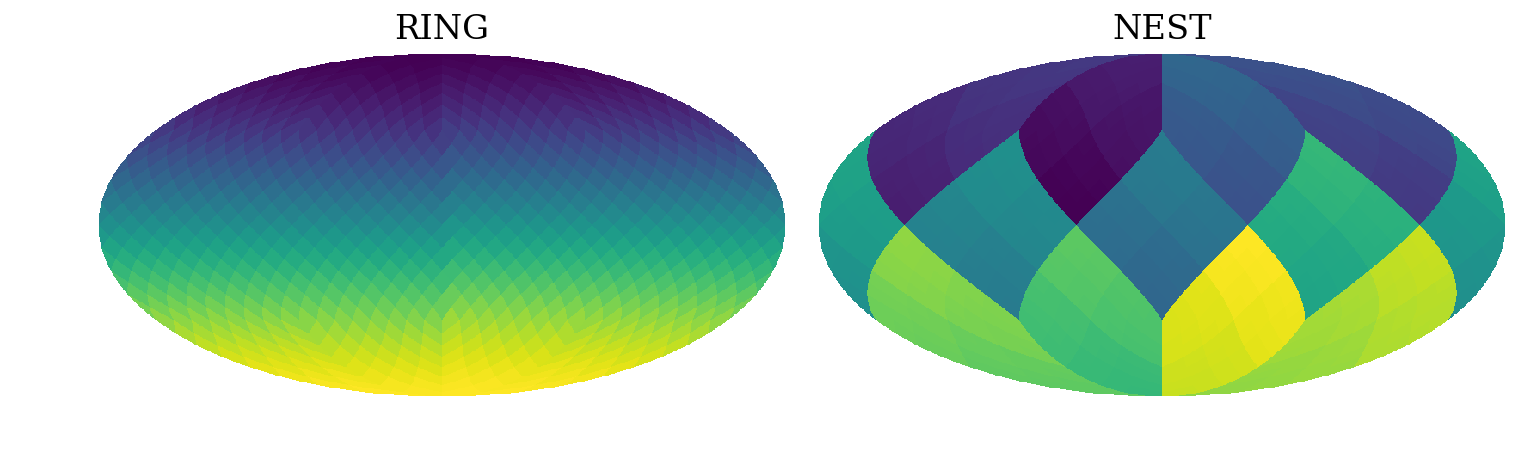

In [5]:
def ring2nestXtrain(xtrainH):
    '''transform every samples in xtrainH to NEST ordering'''
    xtrainHN = np.zeros(xtrainH.shape)
    ipix = hp.ring2nest(nside=hp.npix2nside(xtrainH.shape[-1]), 
                        ipix=np.arange(xtrainH.shape[-1]))
    for i,x in enumerate(xtrainH):
        xtrainHN[i, ipix] = x
    return xtrainHN

# RING ORDERING
hp.mollview(np.arange(hp.nside2npix(8)), 
            title='RING', cbar=0, sub=(1,2,1))
# NEST ORDERING
hp.mollview(np.arange(hp.nside2npix(8)), nest=1, 
            title='NEST', cbar=0, sub=(1,2,2))

xtrainHN = ring2nestXtrain(xtrainH)
xtestHN  = ring2nestXtrain(xtestH)

# Preprocessing Data

The tradition of preprocessing on MNIST is to divide by 255 for each sample, and one-hot encode the target samples (0~9). Here we just repeat the same tradition.

In [6]:
num_classes = 10

# feature scaling 
xtrainHN /= 255.
xtestHN  /= 255.

# one-hot encodeing for target samples
ytrain = keras.utils.to_categorical(ytrain, num_classes)
ytest  = keras.utils.to_categorical(ytest,  num_classes)

# add a dimension for channels, since we are in gray scale 
# just add (1, ) for additional dimension
if K.image_data_format() == 'channels_last': # it's my case
    xtrainHN = xtrainHN.reshape(xtrainHN.shape + (1, ))
    xtestHN  = xtestHN.reshape(xtestHN.shape + (1, ))
else: 
    xtrainHN = xtrainHN.reshape((1, ) + xtrainHN.shape)
    xtestHN  = xtestHN.reshape((1, ) + xtestHN.shape)

# CNN model for Spherical Data

Let's try out with a simple `1DConv` model on spherical MNIST data. The structure works like the below Figure. Because we only want to know whether it would work for Healpix data, we simply setup the model with 2 layers of `1DConv` and 2 additional `Dense` layer. 

In [7]:
input_shape = xtrainHN.shape[1:]
batch_size  = 128
epochs      = 100

model = Sequential()

# Nside = 8 -> Nside = 4
model.add(Conv1D(32, kernel_size=(4, ), strides=4, activation='relu', 
                 input_shape=input_shape))
# Nside = 4 -> Nside = 2 (48 pixels)
model.add(Conv1D(64, kernel_size=(4, ), strides=4, activation='relu'))

# Flatten to Dense
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Hope this will work anyway
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 192, 32)           160       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 64)            8256      
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               393344    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 403,050
Trainable params: 403,050
Non-trainable params: 0
_________________________________________________________________


In [9]:
# keras useful callbacks 
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, 
                                         write_graph=True, write_images=True)
history    = keras.callbacks.History()
earlystop  = keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)

model.fit(xtrainHN, ytrain, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(xtestHN, ytest), 
          callbacks=[tbCallBack, history, earlystop],)

# score evaluation
score = model.evaluate(xtestHN, ytest, verbose=0)
print('Test loss:',     score[0])
print('Test accuracy:', score[1])

Test loss: 0.06890445908847323
Test accuracy: 0.9807


# Training History

Just run for a few epochs, you can see (in Figure) the accuracy increase normally as the ordinary MNIST training on square images. Though further validation on training MNIST Healpix with rotations will be needed, in this simplest case, you see can the training on Healpix data works just fine. 

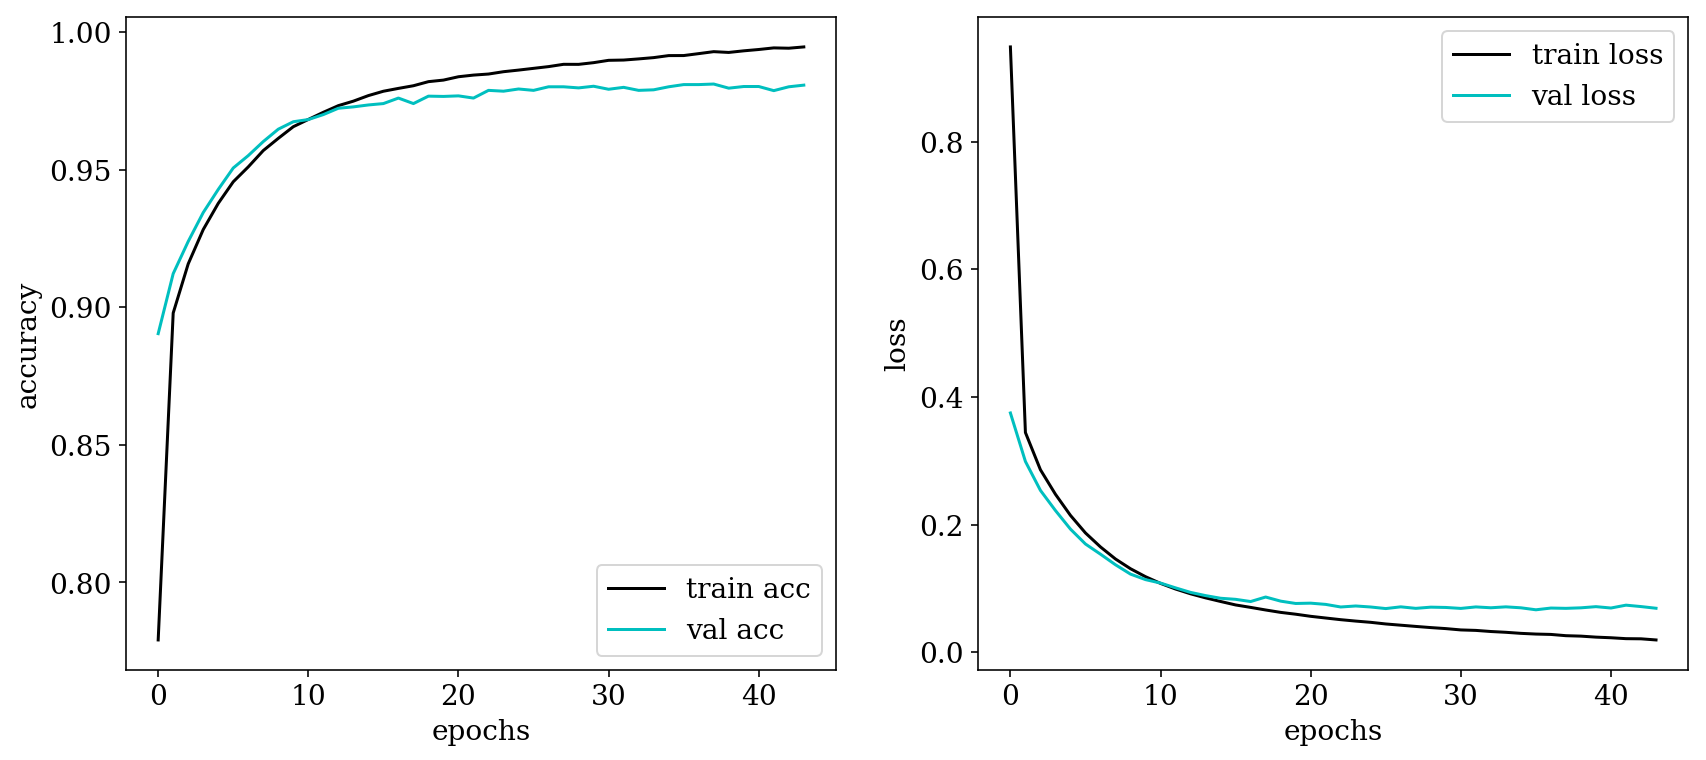

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(history.history['acc'], label='train acc')
ax[0].plot(history.history['val_acc'], label='val acc')
#plt.ylim(0, 1)
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epochs')
ax[0].legend()

ax[1].plot(history.history['loss'], label='train loss')
ax[1].plot(history.history['val_loss'], label='val loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epochs')
ax[1].legend()

# Visualize Feature Maps

We can visualize the output for each layer in the CNN model using Healpix projection. Here we take an image of `digit=2` for an example and select a few filters for each CNN layer. You can see the output feature maps for first layer and second layer in the below Figure. 

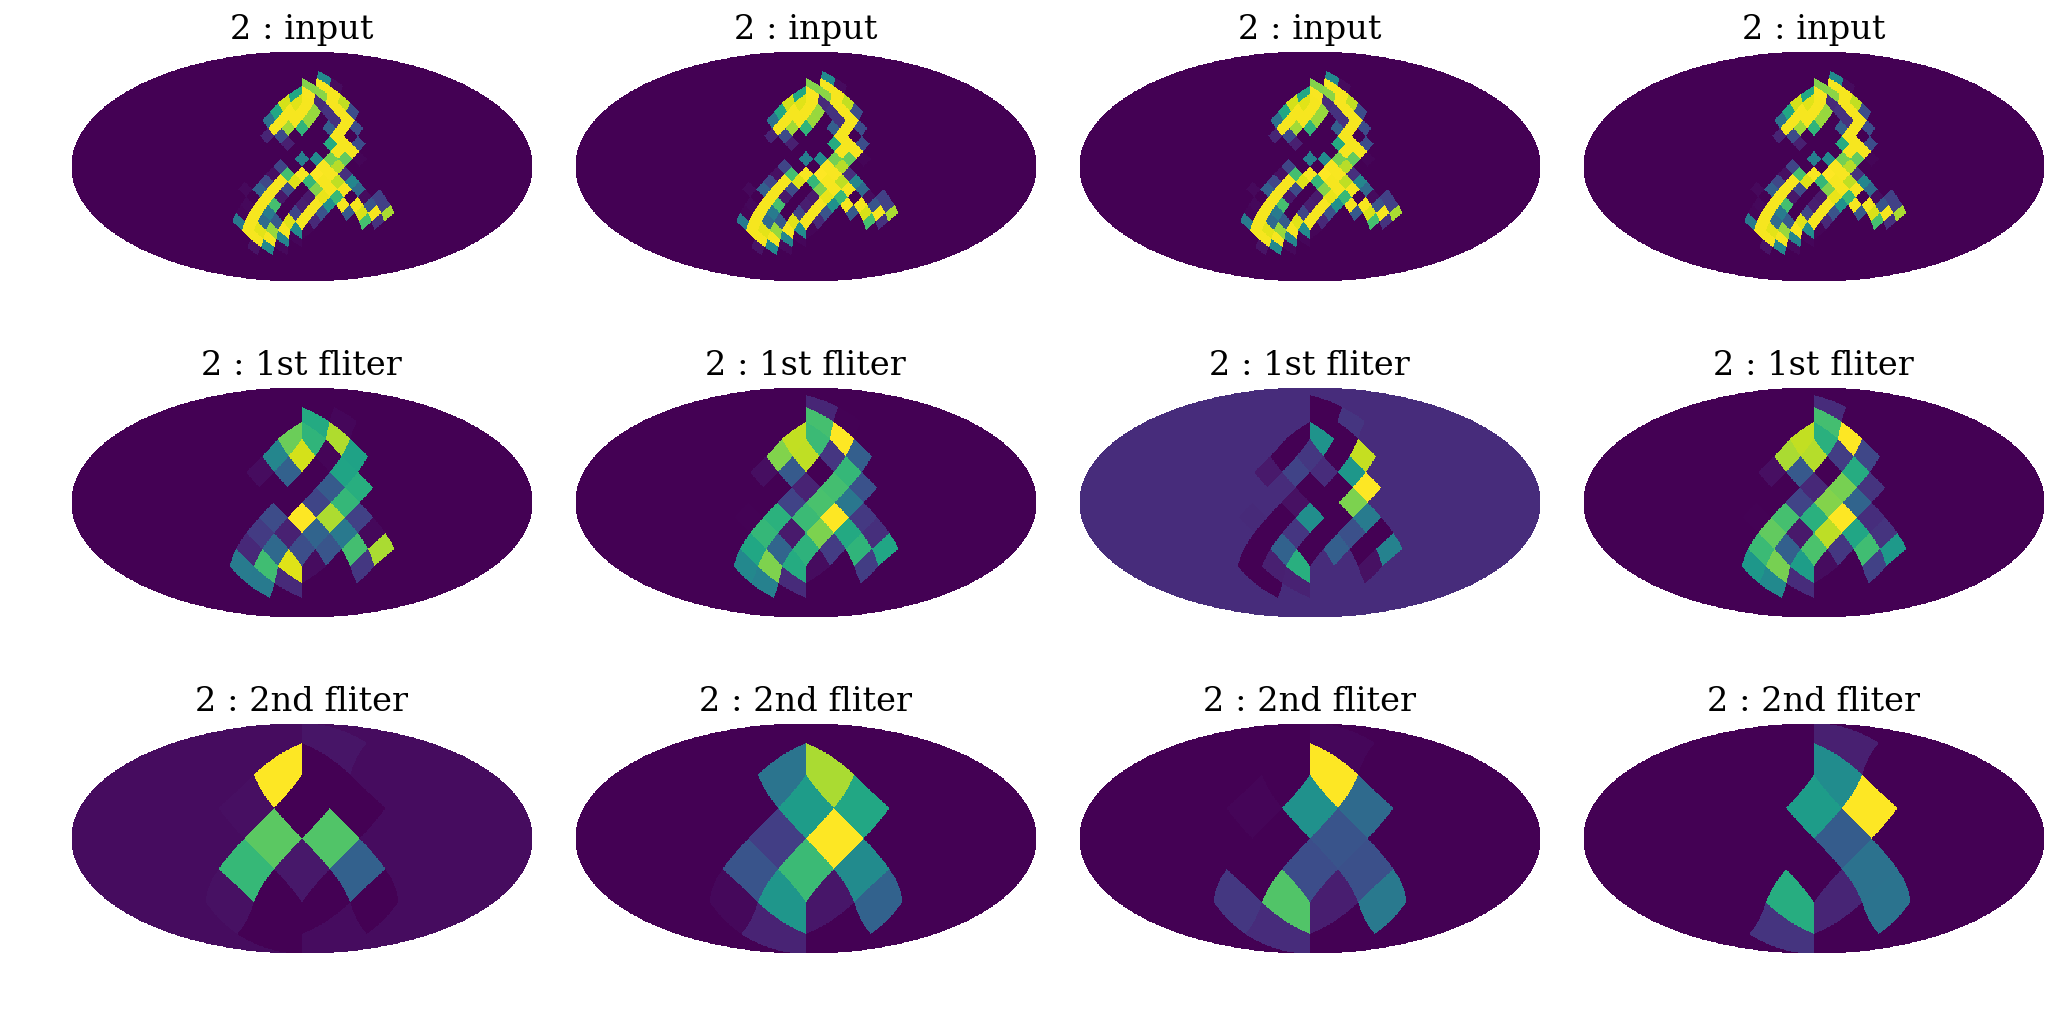

In [11]:
firstModel = Sequential()
firstModel.add(model.layers[0])
xtrainPredict = firstModel.predict(xtrainHN)

plt.figure(figsize=(14, 7))
hp.mollview(xtrainHN[5, :, 0].reshape(768), nest=1, 
            sub=(3,4,1), title='2 : input', cbar=0)
hp.mollview(xtrainHN[5, :, 0].reshape(768), nest=1, 
            sub=(3,4,2), title='2 : input', cbar=0)
hp.mollview(xtrainHN[5, :, 0].reshape(768), nest=1, 
            sub=(3,4,3), title='2 : input', cbar=0)
hp.mollview(xtrainHN[5, :, 0].reshape(768), nest=1, 
            sub=(3,4,4), title='2 : input', cbar=0)

hp.mollview(xtrainPredict[5, :, 0].reshape(192), nest=1, 
            sub=(3,4,5), title='2 : 1st fliter', cbar=0)
hp.mollview(xtrainPredict[5, :, 1].reshape(192), nest=1, 
            sub=(3,4,6), title='2 : 1st fliter', cbar=0)
hp.mollview(xtrainPredict[5, :, 2].reshape(192), nest=1, 
            sub=(3,4,7), title='2 : 1st fliter', cbar=0)
hp.mollview(xtrainPredict[5, :, 3].reshape(192), nest=1, 
            sub=(3,4,8), title='2 : 1st fliter', cbar=0)

secondModel = Sequential()
secondModel.add(model.layers[0])
secondModel.add(model.layers[1])
xtrainPredict = secondModel.predict(xtrainHN)

hp.mollview(xtrainPredict[5, :, 5].reshape(48), nest=1, 
            sub=(3,4,9), title='2 : 2nd fliter', cbar=0)
hp.mollview(xtrainPredict[5, :, 1].reshape(48), nest=1, 
            sub=(3,4,10), title='2 : 2nd fliter', cbar=0)
hp.mollview(xtrainPredict[5, :, 2].reshape(48), nest=1, 
            sub=(3,4,11), title='2 : 2nd fliter', cbar=0)
hp.mollview(xtrainPredict[5, :, 3].reshape(48), nest=1, 
            sub=(3,4,12), title='2 : 2nd fliter', cbar=0)

# Discussion: What can we do Next?

So far we briefly describe the trick for applying CNN on a specific spherical data, Healpix. Though MNIST is a relative easy task for CNN, we can see the `1DConv` handles the Healpix data just fine. Several things we can do next:

- Testing: applying some rotations on Healpix MNIST data, and train again to see if `1DConv` could handle this kind of situations.
- Classification on Full-Sky data: the final goal still is to do some interesting deep learning stuff on full-sky data, but the big obstacle here is, so far, I can't find a good resources for a large spherical dataset. 
- Developing a more sophisticated method: the trick applied in this tutorial fully relying on the hierarchical data structure in Healpix, and was only applicable for fix filter sizes ($2\times2$, $4\times4$, $8\times8$...). A more sophisticated method, for more serious tasks, should be developed to adapt any data type and any filter size.